# Применение методов undersampling'а к датасету с примерно сбалансированным соотношением команд по применяемым техникам обфускации

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from typing import List, Tuple, Dict, Union
import csv
import copy
import warnings

warnings.filterwarnings('ignore')

## Объявление путей до файлов с данным и загрузка исходного датасета

In [2]:
SOURCE_POWERSHELL_DATASET: str = r"D:\Obfuscation\data\datasets\POWERSHELL_DATASET.csv"
TOKENIZER_POWERSHELL_DATASET_UPDATED: str = r"D:\Obfuscation\data\datasets\TOKENIZER_DATASET_UPDATED.csv"
WRONG_COMMANDS: str = r"D:\Obfuscation\data\WRONG_COMMANDS.csv"
BALANCED_OBF_METHODS_RATIO: str = r"D:\Obfuscation\data\datasets\balanced_archieve\BALANCED_OBF_METHODS_RATIO_DATASET.csv"

In [23]:
LOWER_OBF_METHODS_INDEX: int = 2
UPPER_OBF_METHODS_INDEX: int = 7

In [3]:
source_df = pd.read_csv(SOURCE_POWERSHELL_DATASET)

In [4]:
source_df.shape

(32210, 10)

In [5]:
obf_methods: List[str] = source_df.columns[2:7].to_list()

## Оценка объектов исходного датасета по разным комбинациям методов обфускации

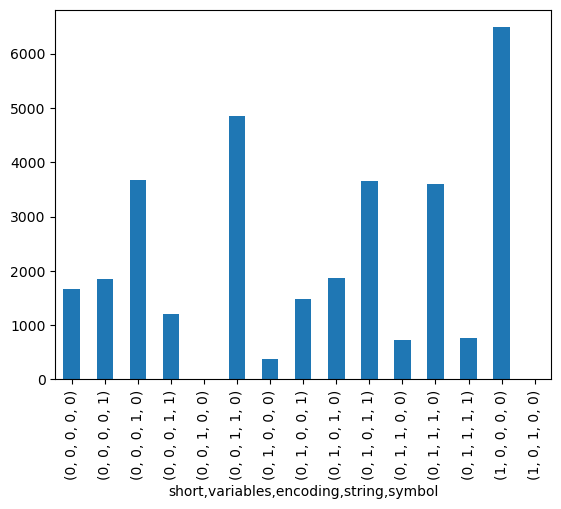

In [6]:
source_df[obf_methods].value_counts(sort=False).plot.bar()
None

In [18]:
combinations: List[str] = [
    "",
    "symbol",
    "string",
    "string, symbol",
    "encoding",
    "encoding, string",
    "variables",
    "variables, symbol",
    "variables, string",
    "variables, string, symbol",
    "variables, encoding",
    "variables, encoding, string",
    "variables, encoding, string, symbol",
    "short",
    "short, encoding",
]
    
counts = source_df[obf_methods].value_counts(sort=False)
limit: int = 2000
    
limit_values_for_combinations: Dict[str, int] = {combination: count if count <= limit else limit for combination, count in zip(combinations, counts)}

In [8]:
counts

short  variables  encoding  string  symbol
0      0          0         0       0         1665
                                    1         1853
                            1       0         3670
                                    1         1208
                  1         0       0            2
                            1       0         4847
       1          0         0       0          384
                                    1         1491
                            1       0         1878
                                    1         3649
                  1         0       0          719
                            1       0         3601
                                    1          758
1      0          0         0       0         6484
                  1         0       0            1
dtype: int64

In [19]:
print("Комбинация ненулевых признаков(методов обфускации): количество объектов.\n")
total_objects: int = 0

for combination, count in limit_values_for_combinations.items():
    print(f"{combination}: {count}")
    total_objects += count
    
print(f"\nВсего объектов в исходном датасете для данных комбинаций(с учетом лимита) = {total_objects}.")

Комбинация ненулевых признаков(методов обфускации): количество объектов.

: 1665
symbol: 1853
string: 2000
string, symbol: 1208
encoding: 2
encoding, string: 2000
variables: 384
variables, symbol: 1491
variables, string: 1878
variables, string, symbol: 2000
variables, encoding: 719
variables, encoding, string: 2000
variables, encoding, string, symbol: 758
short: 2000
short, encoding: 1

Всего объектов в исходном датасете для данных комбинаций(с учетом лимита) = 19959.


## Генерация датасета из исходного и обработанного(токенизированного)

In [10]:
def get_data(filename: str, sep: str = ',') -> List[str]:
    with open(filename, encoding="UTF8") as file:
        reader = csv.reader(file, delimiter=sep)
        for row in reader:
            yield row

In [11]:
def write_csv(filename: str, row: List[Union[str, int, float]]) -> None:
    with open(filename, mode='a', newline='', encoding="UTF8") as file:
        writer = csv.writer(file)
        writer.writerow(row)

In [24]:
def get_obf_methods_combination(row: pd.Series, source_dataframe: pd.DataFrame) -> str:
    obf_methods: List[str] = []
    for i in np.arange(LOWER_OBF_METHODS_INDEX, UPPER_OBF_METHODS_INDEX):
        if row[i] == 1:
            obf_methods.append(source_dataframe.columns[i])
    obf_methods_combination: str = ', '.join(obf_methods)
    return obf_methods_combination

In [25]:
def generate_dataset(source_dataframe: pd.DataFrame, wrong_commands_path: str, tokenizer_dataset_path: str, limit_values_for_combinations: Dict[str, int], generated_dataset_path: str) -> Dict[str, int]:
    wrong_commands_generator = get_data(wrong_commands_path)
    tokenizer_dataset_generator = get_data(tokenizer_dataset_path, sep=';')
    
    wrong_commands_header: List[str] = next(wrong_commands_generator)  # ['row_number', 'command_clear', 'command_obfuscated', 'obfuscated']
    wrong_command_index: int = int(next(wrong_commands_generator, [0])[0]) - 2
    
    tokenizer_dataset_header: List[str] = next(tokenizer_dataset_generator)  # ["feature_name" * 2708, "obfuscated"]
    write_csv(generated_dataset_path, tokenizer_dataset_header)
    
    for row_index, row in source_dataframe.iterrows():
        if row_index == wrong_command_index:
            wrong_command_index = int(next(wrong_commands_generator, [0])[0]) - 2
        else:
            tokenizer_data: List[str] = next(tokenizer_dataset_generator, None)
            if tokenizer_data is None:
                break
            obf_methods_combination: str = get_obf_methods_combination(row, source_dataframe)
            if limit_values_for_combinations.get(obf_methods_combination, 0) > 0:
                limit_values_for_combinations[obf_methods_combination] -= 1
                write_csv(generated_dataset_path, tokenizer_data)
    return limit_values_for_combinations

In [21]:
limit_values_for_combinations_updated: Dict[str, int] = generate_dataset(source_dataframe=source_df, 
                                                                         wrong_commands_path=WRONG_COMMANDS,
                                                                         tokenizer_dataset_path=TOKENIZER_POWERSHELL_DATASET_UPDATED,
                                                                         limit_values_for_combinations=copy.deepcopy(limit_values_for_combinations),
                                                                         generated_dataset_path=BALANCED_OBF_METHODS_RATIO)

In [22]:
print("Комбинация ненулевых признаков(методов обфускации): обновленное (оставшееся) количество объектов(после генерации датасета).\n")
total_remaining_objects: int = 0

for combination, count in limit_values_for_combinations_updated.items():
    print(f"{combination}: {count}")
    total_remaining_objects += count

print(f"\nОставшееся количество объектов в исходном датасете для данных комбинаций(с учетом лимита) = {total_remaining_objects}.")

Комбинация ненулевых признаков(методов обфускации): обновленное (оставшееся) количество объектов(после генерации датасета).

: 15
symbol: 218
string: 0
string, symbol: 12
encoding: 0
encoding, string: 0
variables: 0
variables, symbol: 8
variables, string: 648
variables, string, symbol: 0
variables, encoding: 0
variables, encoding, string: 0
variables, encoding, string, symbol: 0
short: 0
short, encoding: 0

Оставшееся количество объектов в исходном датасете для данных комбинаций(с учетом лимита) = 901.


## Загрузка полученного датасета

In [26]:
balanced_dataset: pd.DataFrame = pd.read_csv(BALANCED_OBF_METHODS_RATIO)

In [27]:
balanced_dataset.shape

(19058, 2709)

In [28]:
balanced_dataset.head()

,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,AstGroupedArrayElementRangeCounts_40-50_Percent,...,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,obfuscated
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.0,14.0,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,7.0,36.0,0.169643,0.250000,0.142857,0.142857,0.142857,0.107143,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,14.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [6]:
X, y = balanced_dataset.iloc[:, :-1], balanced_dataset.iloc[:, -1]

## Применение методов undersampling'а к сгенерированному датасету

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

In [88]:
# def binary_search(value: float, x: List[float], low: int, high: int = None, epsilon: float = 0) -> int:
#     if high is None:
#         high = len(x)
    
#     epsilon = abs(epsilon)
#     while low < high:
#         mid: int = (low + high) // 2
#         left_bound, right_bound = x[mid] - epsilon, x[mid] + epsilon
#         if left_bound <= value <= right_bound:
#             return mid
#         if value < left_bound:
#             low = mid + 1
#         else:
#             high = mid
#     return -1            

In [8]:
def show_indexes(indexes: List[int], title: str = None, step: int = 1) -> None:
    if title is not None:
        print(title)
    start: int = 0
    for end in range(start + step, len(indexes), step):
        print(*indexes[start:end])
        start = end
    print(*indexes[start:])

In [9]:
def plot_2d(ax, X, Y, reduction_transformer, annotate: bool = False, n_components=None, title: str = ""):
    clear_index = []
    for i in range(len(Y)):
        if Y.iloc[i] == 0:
            clear_index.append(i)
    obf_index = list(set(np.arange(0, len(X)))-set(clear_index))

    embedding = []
    if n_components:
        tranformer_embedding = reduction_transformer(n_components=n_components, random_state=42).fit_transform(X)

        tsne_object = TSNE(n_components=2, verbose=0, random_state=42)
        embedding = tsne_object.fit_transform(tranformer_embedding)
    else:
        embedding = reduction_transformer(n_components=2, random_state=42).fit_transform(X)
    
    x_clear = embedding[clear_index, 0]
    y_clear = embedding[clear_index, 1]
    ax.scatter(x_clear, y_clear, color='green')

    x = embedding[obf_index, 0]
    y = embedding[obf_index, 1]
    ax.scatter(x, y, color='red')
    
    obf_covering_index = []

    if annotate:
        epsilon: float = 0.1
        for i, index in enumerate(obf_index):
            for j in range(len(clear_index)):
                if abs(x[i] - x_clear[j]) <= epsilon and abs(y[i] - y_clear[j]) <= epsilon:
                    ax.annotate(index, xy=(x[i], y[i]))
                    obf_covering_index.append(index)
                    break
        show_indexes(indexes=obf_covering_index,
                     title="Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.\n",
                     step=15)
        
    ax.set_title(title)
    
    return ax

In [10]:
def scale_data(scaler, X):
    scaler = scaler.fit(X)
    X_scale = scaler.transform(X)
    return scaler, X_scale

In [11]:
def show_imbalanced_2d_plot(imbalance_obj, X, Y, reduction_transformer, n_components=None, annotate: bool = False):
    X_resampled, y_resampled = imbalance_obj.fit_resample(X, Y)
    print("Default data's resample was completed successfully!")
    
    scaler_minmax = MinMaxScaler()
    scaler_minmax, X_scaled_minmax = scale_data(scaler_minmax, X)
    X_resampled_minmax, y_resampled_minmax = imbalance_obj.fit_resample(X_scaled_minmax, Y)
    print("MinMax scaled data's resample was completed successfully!")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
    plot_2d(ax=ax1,
            X=X_scaled_minmax, 
            Y=Y, 
            n_components=n_components,
            reduction_transformer=reduction_transformer,
            title=f'MinMax нормировка БЕЗ сэмплирования\n {n_components} компонент',
            annotate=annotate)
    plot_2d(ax=ax2, 
            X=X_resampled_minmax, 
            Y=y_resampled_minmax, 
            n_components=n_components, 
            reduction_transformer=reduction_transformer,
            title=f'MinMax нормировка {imbalance_obj} \n {n_components} компонент',
            annotate=annotate)

    return imbalance_obj, X_resampled, y_resampled, X_resampled_minmax, y_resampled_minmax

### ClusterCentroids method (fixed)

In [14]:
cluster_centroids = ClusterCentroids(random_state=42)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 2h 28min 45s
Wall time: 38min 38s


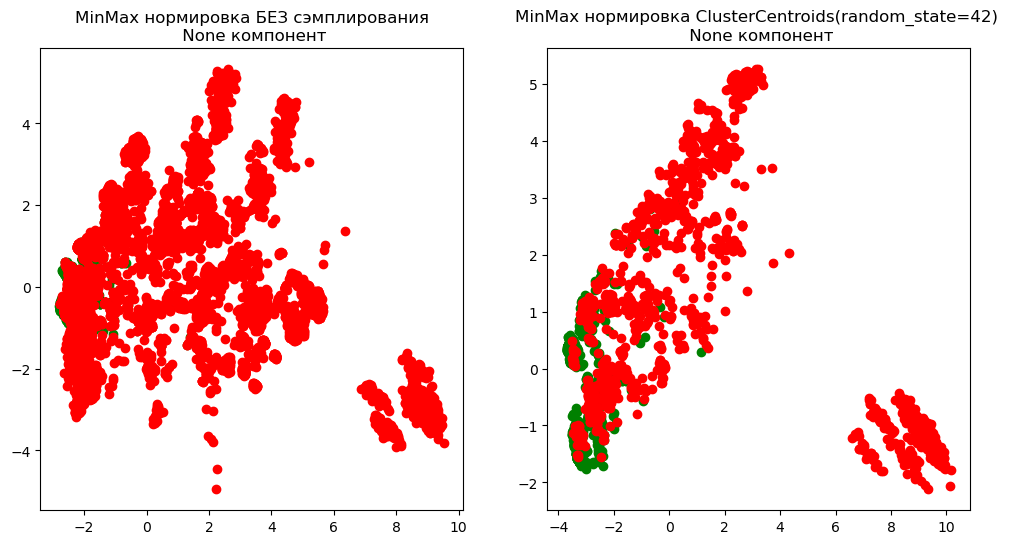

In [12]:
%%time

# n_components = 2, dimension_transformer = PCA
cluster_centroids, clusterCentroids_X, clusterCentroids_y, clusterCentroids_X_minmax, clusterCentroids_y_minmax = show_imbalanced_2d_plot(imbalance_obj=cluster_centroids, 
                                                                                                                                          X=X,
                                                                                                                                          Y=y, 
                                                                                                                                          reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1656 1658 1659 1660 1661 1663 1668 1670 1673 1681 1685 1687 1688 1696
1697 1698 1699 1706 1711 1721 1728 1734 1739 1740 1741 1744 1745 1749 1752
1759 1762 1765 1771 1772 1775 1777 1784 1786 1788 1793 1794 1803 1804 1806
1809 1810 1817 1818 1821 1830 1832 1833 1835 1836 1837 1840 1841 1871 1877
1879 1880 1892 1904 1905 1907 1910 1911 1914 1917 1919 1927 1929 1935 1941
1945 1949 1952 1958 1960 1962 1964 1966 1967 1971 1993 1998 1999 2000 2001
2002 2004 2005 2006 2007 2010 2011 2015 2017 2023 2024 2030 2032 2044 2045
2047 2049 2051 2055 2058 2059 2061 2062 2068 2071 2073 2074 2076 2079 2086
2093 2095 2099 2106 2109 2116 2119 2121 2123 2125 2126 2127 2132 2139 2141
2143 2148 2149 2170 2171 2172 2173 2176 2183 2185 2186 2192 2197 2198 2201
2202 2207 2211 2216 2217 2222 2224 2225 2228 2235 2253 2254 2257 2260 2263
2265 2272 2273 2280 2293 2296 2298 2300 2303 2304 2308 2313 2316 2318 2320
2330 2331

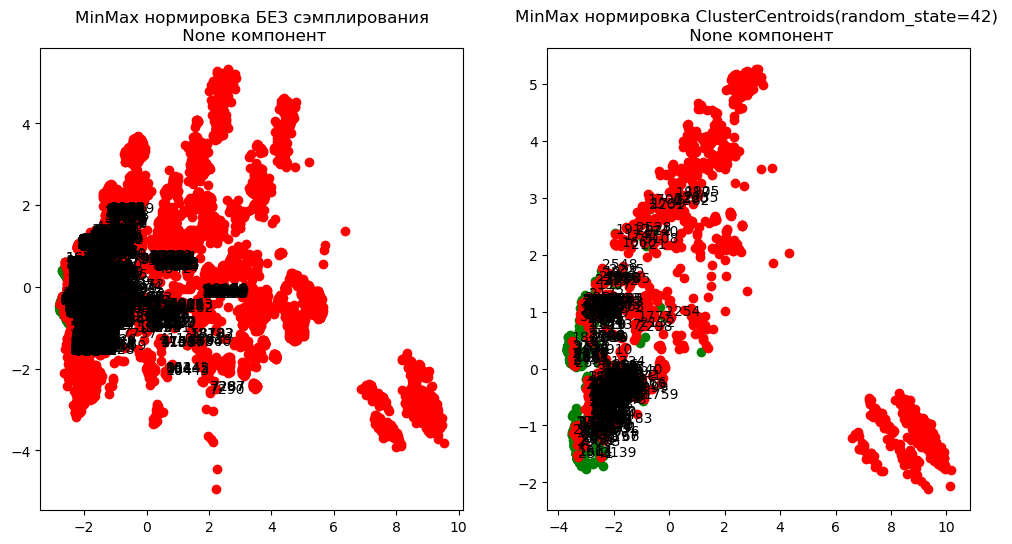

In [15]:
%%time

# n_components = 2, dimension_transformer = PCA
cluster_centroids, clusterCentroids_X, clusterCentroids_y, clusterCentroids_X_minmax, clusterCentroids_y_minmax = show_imbalanced_2d_plot(imbalance_obj=cluster_centroids, 
                                                                                                                                          X=X, 
                                                                                                                                          Y=y, 
                                                                                                                                          reduction_transformer=PCA, 
                                                                                                                                          annotate=True)

In [17]:
clusterCentroids_y_minmax.value_counts()

0    1650
1    1650
Name: obfuscated, dtype: int64

### RandomUnderSampler method (fixed)

In [23]:
random_us = RandomUnderSampler(random_state=42)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 9.73 s
Wall time: 13.9 s


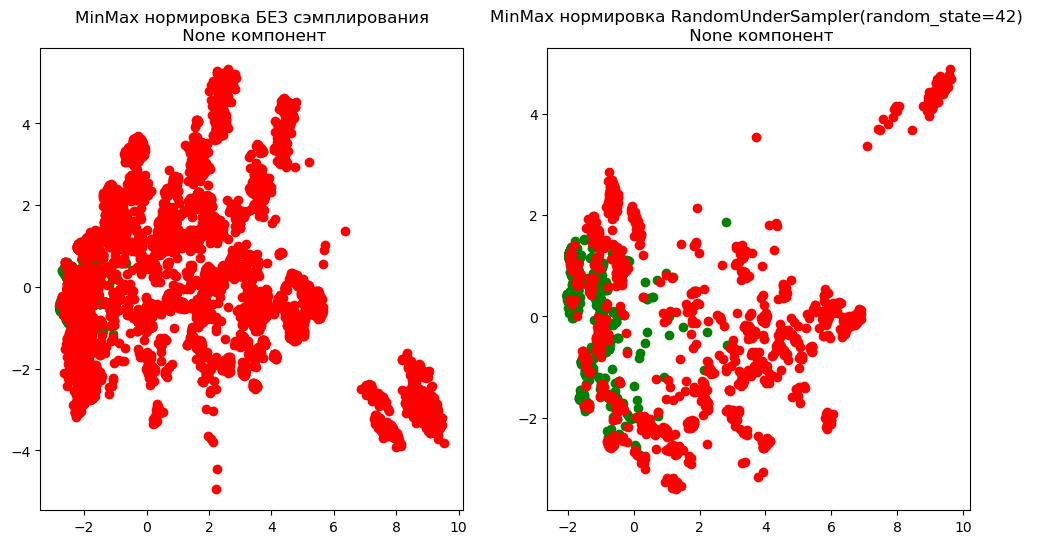

In [85]:
%%time 

# n_components = 2, dimension_transformer = PCA
random_us, randomUnderSampler_X, randomUnderSampler_y, randomUnderSampler_X_minmax, randomUnderSampler_y_minmax = show_imbalanced_2d_plot(imbalance_obj=random_us, 
                                                                                                                                          X=X, 
                                                                                                                                          Y=y, 
                                                                                                                                          reduction_transformer=PCA, 
                                                                                                                                          annotate=False)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1651 1652 1654 1659 1664 1667 1674 1675 1679 1680 1681 1683 1690 1695 1697
1698 1699 1704 1706 1707 1708 1709 1710 1713 1716 1717 1719 1722 1724 1727
1728 1731 1738 1741 1745 1751 1754 1755 1756 1760 1765 1766 1767 1769 1770
1771 1772 1778 1779 1780 1782 1788 1793 1794 1798 1799 1804 1806 1807 1809
1812 1813 1818 1819 1822 1823 1825 1828 1832 1833 1834 1836 1837 1840 1847
1853 1854 1856 1860 1862 1864 1866 1867 1868 1869 1872 1875 1876 1879 1882
1883 1884 1888 1891 1894 1896 1903 1904 1905 1909 1910 1912 1916 1918 1919
1921 1922 1924 1928 1929 1931 1938 1939 1942 1950 1953 1954 1955 1958 1959
1964 1966 1967 1968 1971 1974 1975 1976 1977 1978 1979 1984 1985 1989 1990
1991 1994 1996 2003 2004 2006 2007 2008 2016 2020 2032 2036 2039 2043 2044
2045 2046 2047 2048 2049 2050 2052 2053 2054 2056 2057 2060 2061 2062 2063
2067 2069 2071 2072 2078 2079 2085 2088 2091 2094 2098 2100 2101 2103 2104
2106 2107

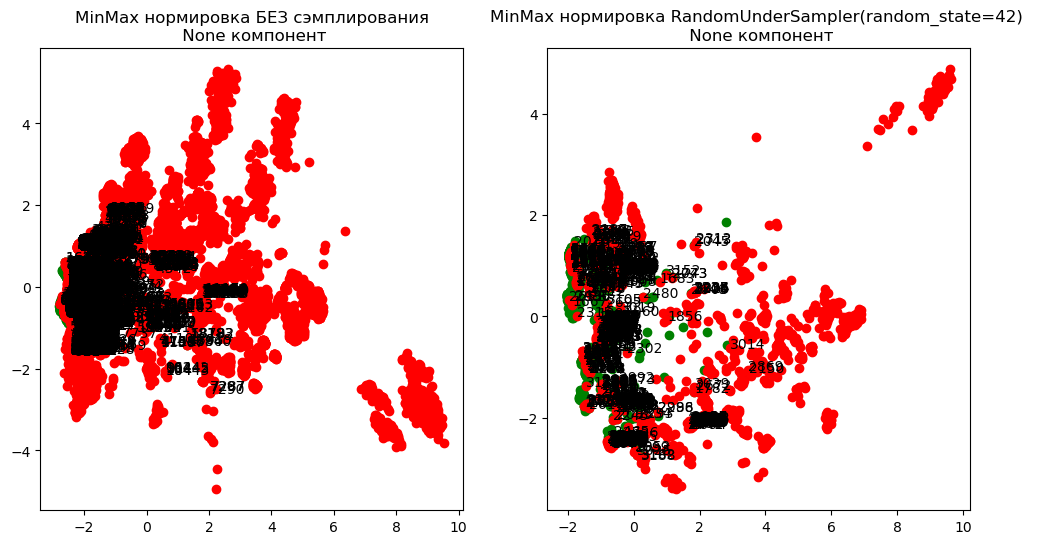

In [86]:
%%time 

# n_components = 2, dimension_transformer = PCA
random_us, randomUnderSampler_X, randomUnderSampler_y, randomUnderSampler_X_minmax, randomUnderSampler_y_minmax = show_imbalanced_2d_plot(imbalance_obj=random_us, 
                                                                                                                                          X=X,
                                                                                                                                          Y=y, 
                                                                                                                                          reduction_transformer=PCA, 
                                                                                                                                          annotate=True)

In [87]:
randomUnderSampler_y_minmax.value_counts()

0    1650
1    1650
Name: obfuscated, dtype: int64

### CondensedNearestNeighbour method (cleaning)

In [26]:
condensedNearestNeighbour = CondensedNearestNeighbour(random_state=42, n_jobs=-1)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 4h 22min 6s
Wall time: 1h 14min 18s


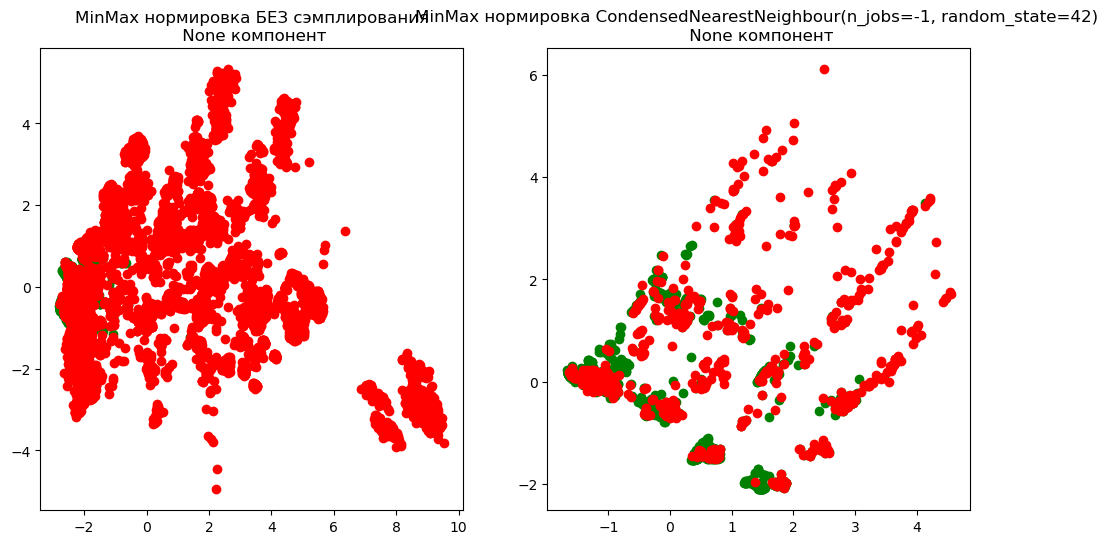

In [27]:
%%time 

# n_components = 2, dimension_transformer = PCA
condensedNearestNeighbour, condensedNearestNeighbour_X, condensedNearestNeighbour_y, condensedNearestNeighbour_X_minmax, condensedNearestNeighbour_y_minmax = show_imbalanced_2d_plot(imbalance_obj=condensedNearestNeighbour, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

In [ ]:
%%time 

# n_components = 2, dimension_transformer = PCA
condensedNearestNeighbour, condensedNearestNeighbour_X, condensedNearestNeighbour_y, condensedNearestNeighbour_X_minmax, condensedNearestNeighbour_y_minmax = show_imbalanced_2d_plot(imbalance_obj=condensedNearestNeighbour, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [28]:
condensedNearestNeighbour_y_minmax.value_counts()

0    1650
1     771
Name: obfuscated, dtype: int64

###  TomekLinks method (cleaning)

In [19]:
tomekLinks = TomekLinks(n_jobs=-1)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 3min 11s
Wall time: 55.3 s


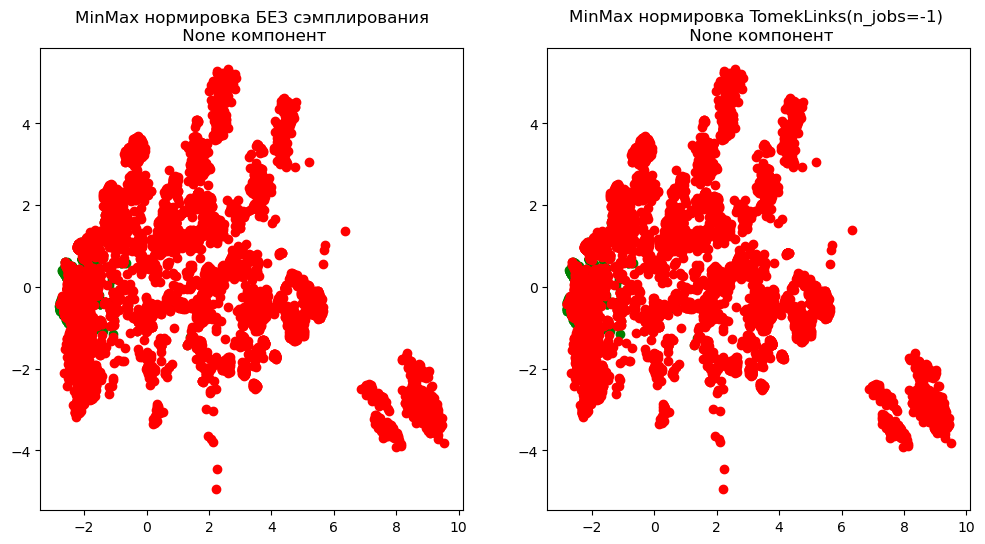

In [30]:
%%time 

# n_components = 2, dimension_transformer = PCA
tomekLinks, tomekLinks_X, tomekLinks_y, tomekLinks_X_minmax, tomekLinks_y_minmax = show_imbalanced_2d_plot(imbalance_obj=tomekLinks, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 860 862 863
864 865 866 867 869 873 876 879 880 889 891 892 893 894 895
896 901 903 910 921 928 930 933 936 947 949 950 952 953 954
955 956 957 958 959 962 965 976 979 980 981 982 983 984 985
986 1006 1007 1008 1009 1010 1011 1015 1018 1027 1028 1031 1032 1033 1034
1035 1036 1037 1038 1040 1054 1055 1056 1057 1058 1059 1060 1063 1065 1075
1076 1078 1079 1080 1081 1082 1083 1086 1088 1089 1099 1103 1104 1105 1106
1107 1108 1110 1126 1127 1128 1129 1130 1131 1132 1133 1144 1148 1149 1150
1151 1152 1153 1154 1155 1158 1173 1174 1175 1176 1177 1178 1179 1180 1183
1186 1187 1199 1201 1202 1203 1204 1205 1206 1207 1208 1210 1221 1225 1226
1227 1228 1229 1230 1233 1245 1247 1248 1250 1251 1252 1253 1254 1255 1256
1257 1260 1263 1264 1274 1277 1278 1279 1280 1281 1282 1283 1284 1287 1301
1303 1304 1305 1306 1307 1308 1309 1310 1311 1312 1315 1318 1319 1334 

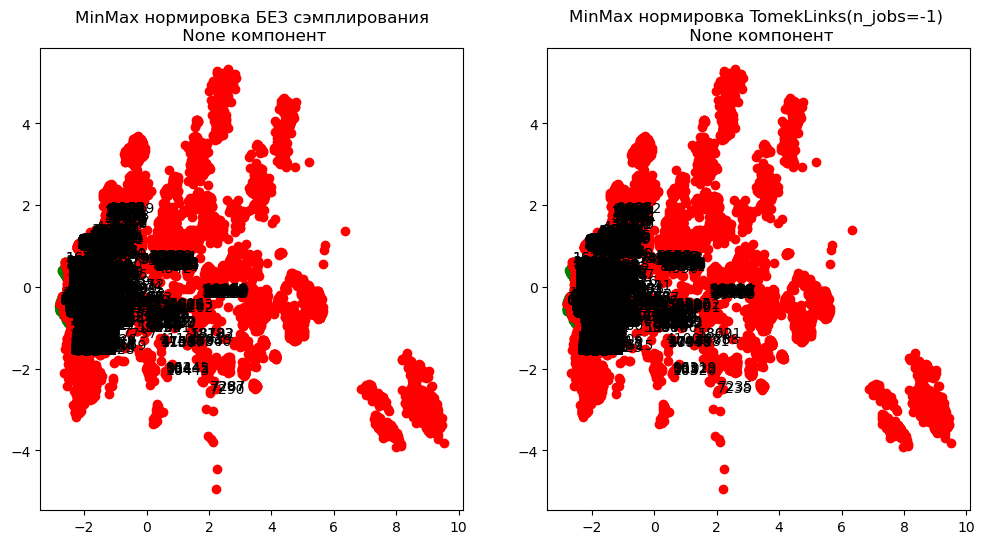

In [20]:
%%time 

# n_components = 2, dimension_transformer = PCA
tomekLinks, tomekLinks_X, tomekLinks_y, tomekLinks_X_minmax, tomekLinks_y_minmax = show_imbalanced_2d_plot(imbalance_obj=tomekLinks, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [21]:
tomekLinks_y_minmax.value_counts()

1    17245
0     1650
Name: obfuscated, dtype: int64

### OneSidedSelection method (cleaning)

In [23]:
oneSidedSelection = OneSidedSelection(random_state=42, n_jobs=-1)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 3min 20s
Wall time: 57.9 s


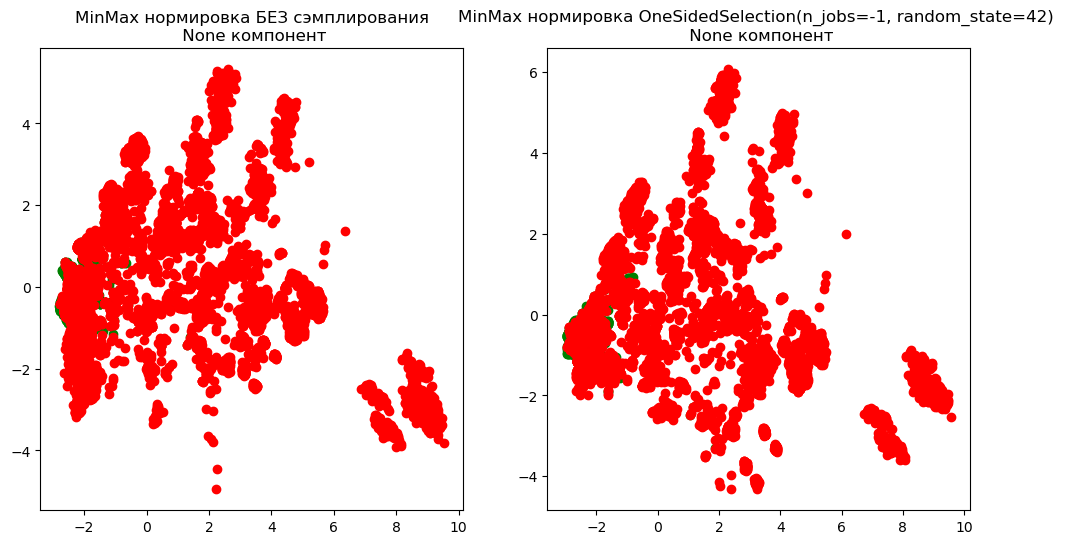

In [33]:
%%time 

# n_components = 2, dimension_transformer = PCA
oneSidedSelection, oneSidedSelection_X, oneSidedSelection_y, oneSidedSelection_X_minmax, oneSidedSelection_y_minmax = show_imbalanced_2d_plot(imbalance_obj=oneSidedSelection, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1652 1661 1662 1667 1668 1672 1677 1688 1689 1690 1691 1692 1693
1694 1695 1699 1702 1703 1704 1705 1706 1715 1716 1717 1718 1719 1720 1725
1727 1730 1733 1734 1744 1750 1751 1752 1755 1758 1770 1771 1772 1774 1775
1776 1777 1778 1779 1780 1781 1784 1787 1797 1798 1799 1800 1801 1802 1803
1804 1805 1806 1825 1826 1827 1828 1829 1830 1831 1835 1838 1847 1849 1850
1851 1852 1853 1854 1855 1856 1857 1859 1870 1871 1872 1873 1874 1875 1876
1877 1878 1881 1883 1884 1893 1894 1895 1896 1897 1898 1899 1900 1901 1904
1906 1917 1918 1920 1922 1923 1924 1925 1926 1928 1941 1944 1945 1946 1947
1948 1949 1950 1951 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971
1972 1975 1985 1986 1987 1989 1990 1991 1992 1993 1994 1995 1996 1999 2002
2011 2012 2013 2015 2016 2017 2018 2019 2020 2021 2022 2024 2036 2037 2039
2040 2041 2042 2043 2044 2047 2058 2059 2060 2061 2062 2063 2064 2065 2066
2067 2068

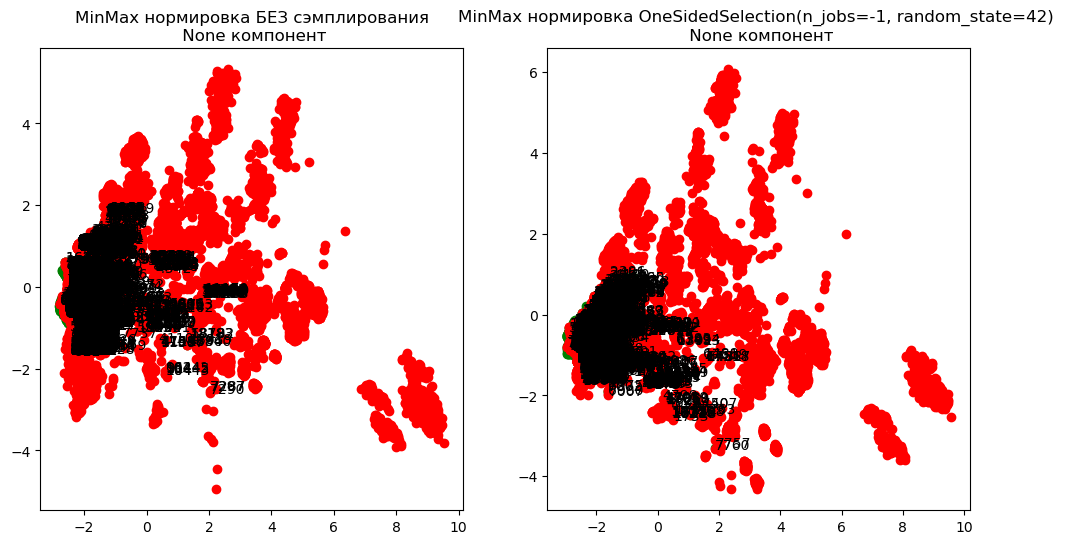

In [24]:
%%time 

# n_components = 2, dimension_transformer = PCA
oneSidedSelection, oneSidedSelection_X, oneSidedSelection_y, oneSidedSelection_X_minmax, oneSidedSelection_y_minmax = show_imbalanced_2d_plot(imbalance_obj=oneSidedSelection, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [25]:
oneSidedSelection_y_minmax.value_counts()

1    15885
0     1650
Name: obfuscated, dtype: int64

### EditedNearestNeighbours (cleaning)

#### Без аннотаций

In [26]:
editedNearestNeighbours_all = EditedNearestNeighbours(n_jobs=-1, kind_sel='all')

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 2min 52s
Wall time: 49.4 s


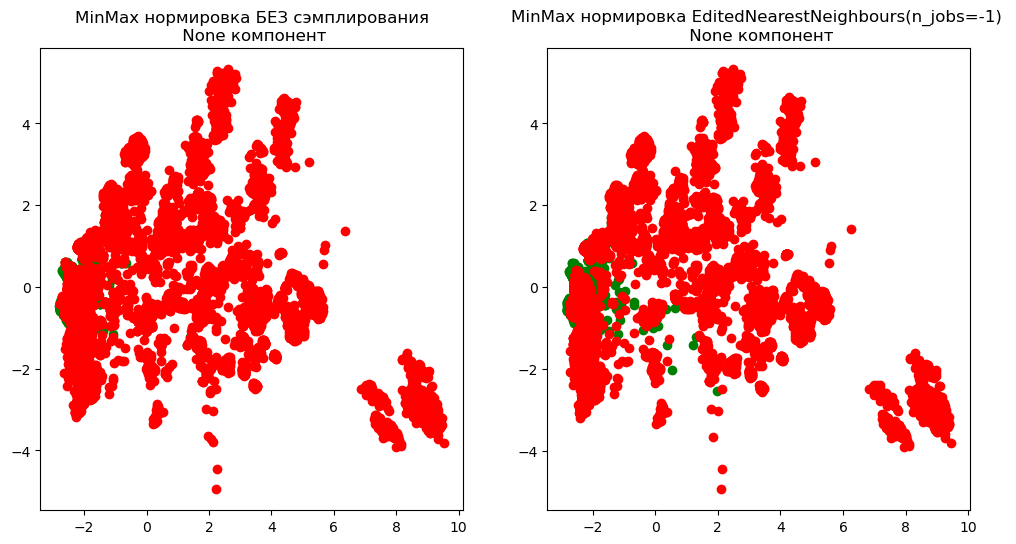

In [35]:
%%time

# n_components = 2, dimension_transformer = PCA
editedNearestNeighbours_all, editedNearestNeighbours_all_X, editedNearestNeighbours_all_y, editedNearestNeighbours_all_X_minmax, editedNearestNeighbours_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=editedNearestNeighbours_all, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1662 1663 1664 1665 1666 1667 1668 1674 1686 1688 1689 1690 1691
1692 1693 1695 1701 1711 1713 1714 1715 1716 1717 1718 1759 1760 1761 1762
1764 1765 1766 1767 1768 1769 1770 1771 1776 1787 1790 1791 1792 1793 1794
1795 1796 1797 1817 1818 1819 1820 1821 1822 1836 1837 1840 1841 1842 1843
1844 1845 1846 1847 1862 1863 1864 1865 1866 1867 1868 1872 1882 1883 1885
1886 1887 1888 1889 1890 1894 1895 1905 1909 1910 1911 1912 1913 1914 1931
1932 1933 1934 1935 1936 1937 1938 1949 1953 1954 1955 1956 1957 1958 1959
1960 1977 1978 1979 1980 1981 1982 1983 1984 1989 1990 2002 2004 2005 2006
2007 2008 2009 2010 2023 2027 2028 2029 2030 2031 2046 2048 2049 2051 2052
2053 2054 2055 2056 2057 2058 2063 2064 2074 2077 2078 2079 2080 2081 2082
2083 2084 2100 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111 2129 2130
2131 2132 2133 2134 2135 2148 2151 2154 2155 2156 2157 2158 2159 2160 2161
2175 2176

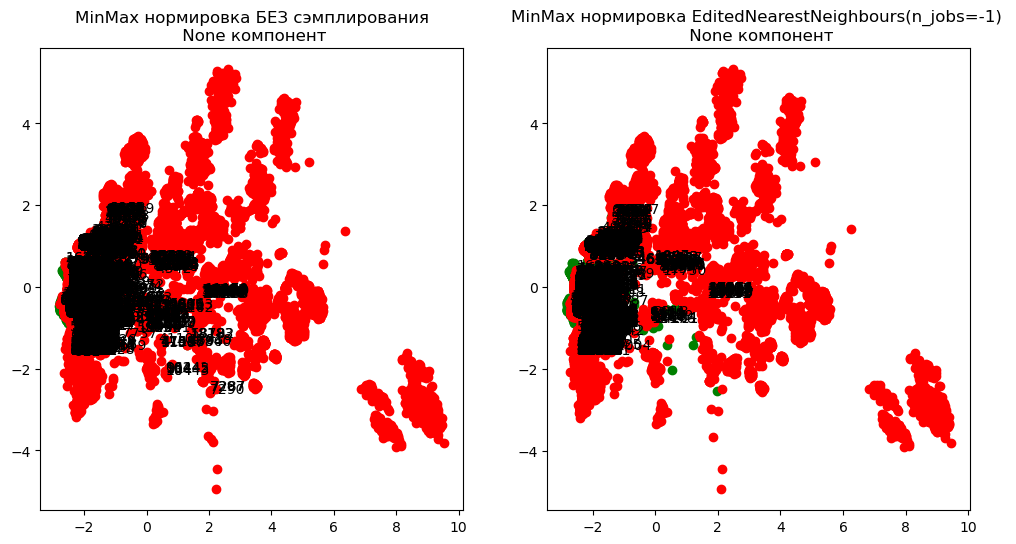

In [27]:
%%time
# n_components = 2, dimension_transformer = PCA
editedNearestNeighbours_all, editedNearestNeighbours_all_X, editedNearestNeighbours_all_y, editedNearestNeighbours_all_X_minmax, editedNearestNeighbours_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=editedNearestNeighbours_all, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [28]:
editedNearestNeighbours_all_y_minmax.value_counts()

1    16483
0     1650
Name: obfuscated, dtype: int64

#### Без аннотаций

In [29]:
editedNearestNeighbours_mode = EditedNearestNeighbours(n_jobs=-1, kind_sel='mode')

D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)


Default data's resample was completed successfully!


D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)


MinMax scaled data's resample was completed successfully!
CPU times: total: 2min 52s
Wall time: 52.6 s


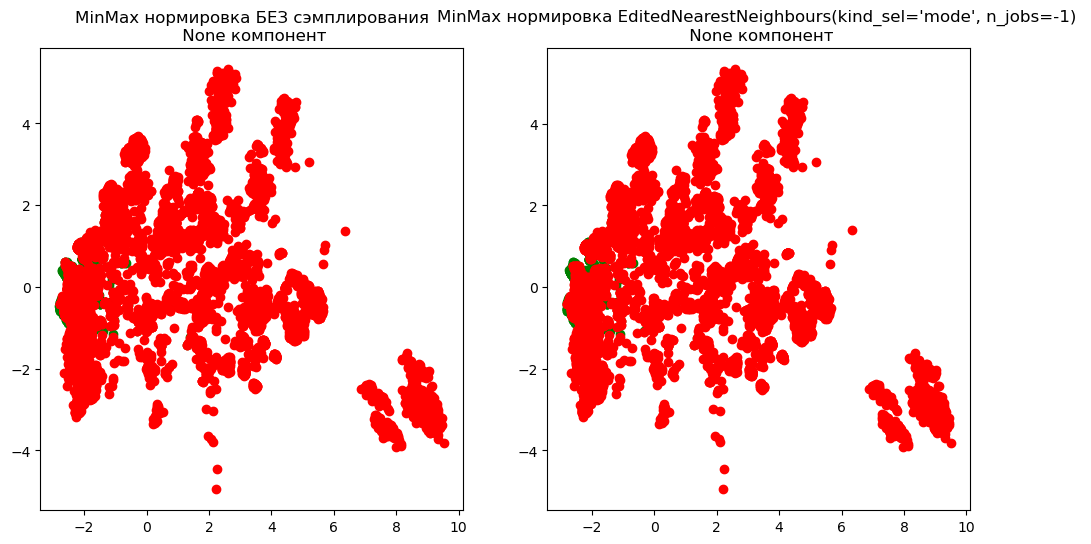

In [37]:
%%time 
# n_components = 2, dimension_transformer = PCA
editedNearestNeighbours_mode, editedNearestNeighbours_mode_X, editedNearestNeighbours_mode_y, editedNearestNeighbours_mode_X_minmax, editedNearestNeighbours_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=editedNearestNeighbours_mode, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1662 1663 1664 1665 1666 1667 1668 1672 1675 1677 1678 1689 1691
1692 1693 1694 1695 1696 1698 1702 1705 1708 1709 1718 1720 1721 1722 1723
1724 1725 1730 1732 1739 1750 1757 1759 1762 1765 1776 1778 1779 1781 1782
1783 1784 1785 1786 1787 1788 1791 1794 1805 1808 1809 1810 1811 1812 1813
1814 1815 1835 1836 1837 1838 1839 1840 1854 1855 1858 1859 1860 1861 1862
1863 1864 1865 1867 1881 1882 1883 1884 1885 1886 1887 1890 1892 1902 1903
1905 1906 1907 1908 1909 1910 1913 1915 1916 1926 1930 1931 1932 1933 1934
1935 1937 1953 1954 1955 1956 1957 1958 1959 1960 1971 1975 1976 1977 1978
1979 1980 1981 1982 1985 2000 2001 2002 2003 2004 2005 2006 2007 2010 2013
2014 2026 2028 2029 2030 2031 2032 2033 2034 2035 2037 2048 2052 2053 2054
2055 2056 2057 2060 2072 2074 2075 2077 2078 2079 2080 2081 2082 2083 2084
2087 2090 2091 2101 2104 2105 2106 2107 2108 2109 2110 2111 2114 2128 2130
2131 2132

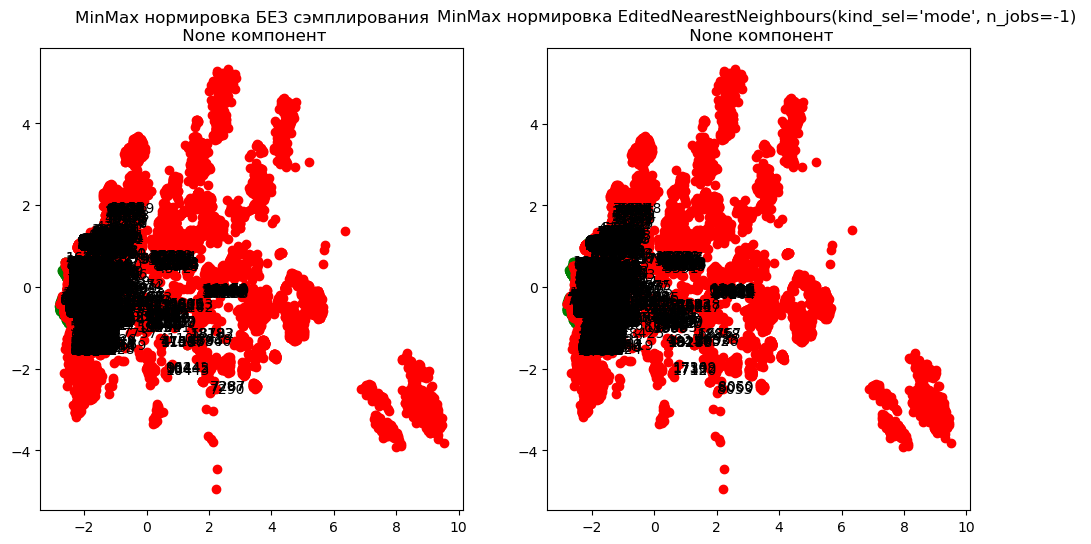

In [30]:
%%time
# n_components = 2, dimension_transformer = PCA
editedNearestNeighbours_mode, editedNearestNeighbours_mode_X, editedNearestNeighbours_mode_y, editedNearestNeighbours_mode_X_minmax, editedNearestNeighbours_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=editedNearestNeighbours_mode, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [31]:
editedNearestNeighbours_mode_y_minmax.value_counts()

1    17254
0     1650
Name: obfuscated, dtype: int64

### RepeatedEditedNearestNeighbours (cleaning)

#### Без аннотаций

In [32]:
repeatedEditedNN_all = RepeatedEditedNearestNeighbours(kind_sel='all', n_jobs=-1)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 15min 44s
Wall time: 4min 13s


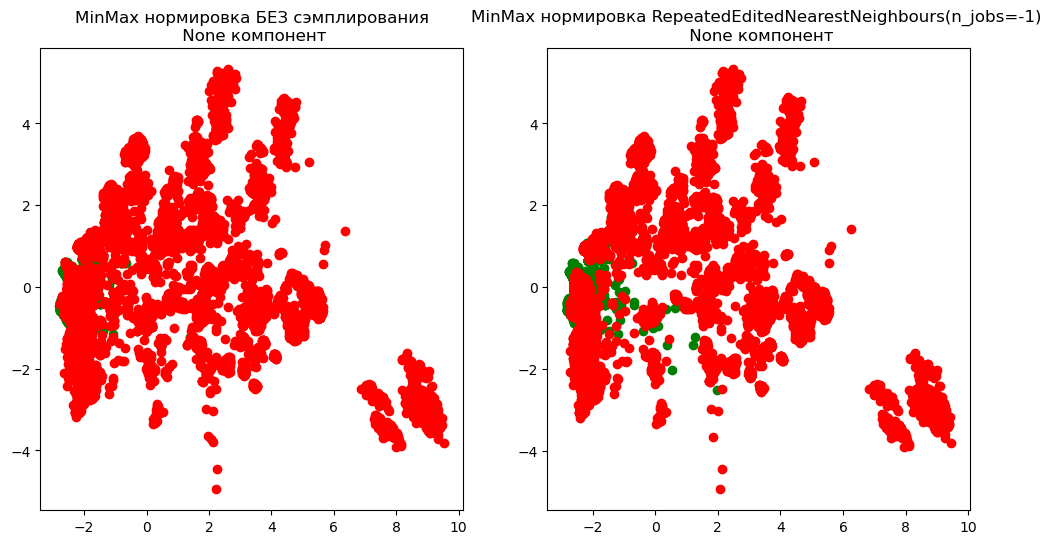

In [39]:
%%time
# n_components = 2, dimension_transformer = PCA
repeatedEditedNN_all, repeatedEditedNN_all_X, repeatedEditedNN_all_y, repeatedEditedNN_all_X_minmax, repeatedEditedNN_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=repeatedEditedNN_all, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1662 1663 1664 1665 1666 1667 1668 1685 1687 1688 1689 1690 1691
1692 1694 1700 1710 1712 1713 1714 1715 1716 1717 1755 1756 1757 1758 1760
1761 1762 1763 1764 1765 1766 1767 1772 1783 1786 1787 1788 1789 1790 1791
1792 1793 1813 1814 1815 1816 1817 1818 1832 1833 1836 1837 1838 1839 1840
1841 1842 1843 1858 1859 1860 1861 1862 1863 1864 1868 1878 1879 1881 1882
1883 1884 1885 1886 1890 1900 1901 1904 1905 1906 1907 1908 1909 1926 1927
1928 1929 1930 1931 1932 1933 1944 1945 1948 1949 1950 1951 1952 1953 1954
1955 1972 1973 1974 1975 1976 1977 1978 1979 1996 1998 1999 2000 2001 2002
2003 2004 2017 2021 2022 2023 2024 2025 2040 2042 2043 2045 2046 2047 2048
2049 2050 2051 2052 2057 2058 2068 2071 2072 2073 2074 2075 2076 2077 2078
2094 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2123 2124 2125 2126
2127 2128 2129 2142 2145 2148 2149 2150 2151 2152 2153 2154 2155 2169 2170
2171 2172

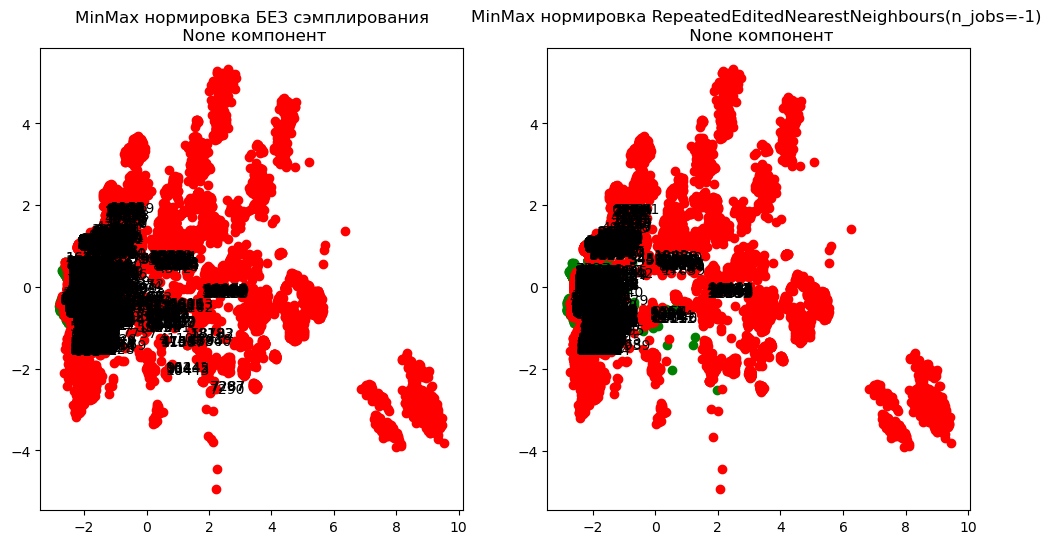

In [33]:
%%time
# n_components = 2, dimension_transformer = PCA
repeatedEditedNN_all, repeatedEditedNN_all_X, repeatedEditedNN_all_y, repeatedEditedNN_all_X_minmax, repeatedEditedNN_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=repeatedEditedNN_all, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [34]:
repeatedEditedNN_all_y_minmax.value_counts()

1    16388
0     1650
Name: obfuscated, dtype: int64

#### Без аннотаций

In [35]:
repeatedEditedNN_mode = RepeatedEditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is

Default data's resample was completed successfully!


D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is

MinMax scaled data's resample was completed successfully!
CPU times: total: 15min 37s
Wall time: 4min 11s


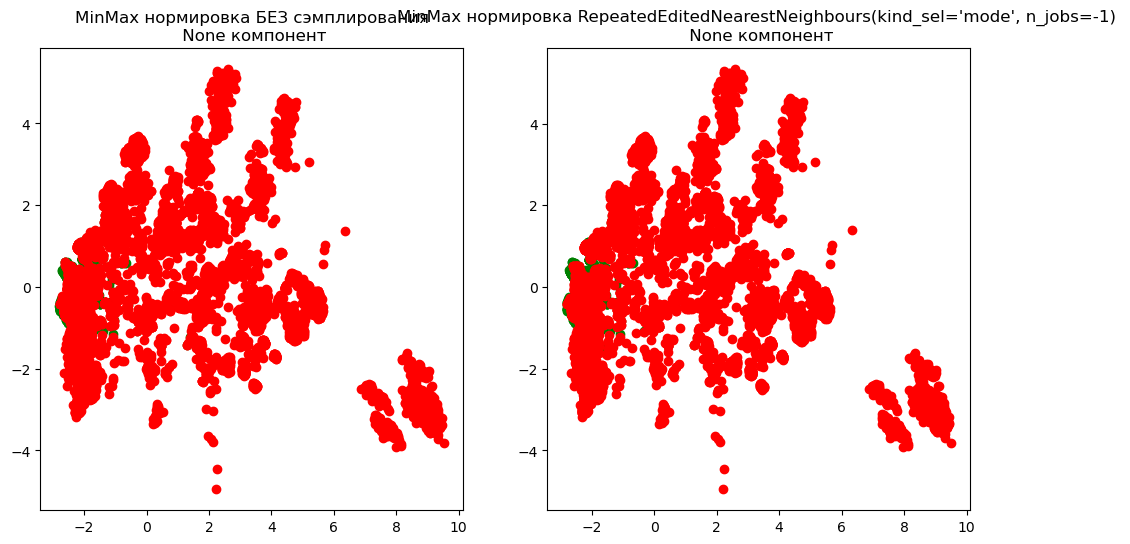

In [41]:
%%time
# n_components = 2, dimension_transformer = PCA
repeatedEditedNN_mode, repeatedEditedNN_mode_X, repeatedEditedNN_mode_y, repeatedEditedNN_mode_X_minmax, repeatedEditedNN_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=repeatedEditedNN_mode, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1662 1663 1664 1665 1666 1667 1668 1672 1675 1677 1678 1689 1691
1692 1693 1694 1695 1696 1698 1702 1705 1708 1709 1718 1720 1721 1722 1723
1724 1725 1730 1732 1739 1750 1757 1759 1762 1765 1776 1778 1779 1781 1782
1783 1784 1785 1786 1787 1788 1791 1794 1808 1809 1810 1811 1812 1813 1814
1815 1835 1836 1837 1838 1839 1840 1854 1855 1858 1859 1860 1861 1862 1863
1864 1865 1867 1881 1882 1883 1884 1885 1886 1887 1890 1892 1902 1903 1905
1906 1907 1908 1909 1910 1913 1915 1916 1926 1930 1931 1932 1933 1934 1935
1937 1953 1954 1955 1956 1957 1958 1959 1960 1971 1975 1976 1977 1978 1979
1980 1981 1982 1985 2000 2001 2002 2003 2004 2005 2006 2007 2010 2013 2014
2026 2028 2029 2030 2031 2032 2033 2034 2035 2037 2048 2052 2053 2054 2055
2056 2057 2060 2072 2074 2075 2077 2078 2079 2080 2081 2082 2083 2084 2087
2090 2091 2101 2104 2105 2106 2107 2108 2109 2110 2111 2114 2128 2130 2131
2132 2133

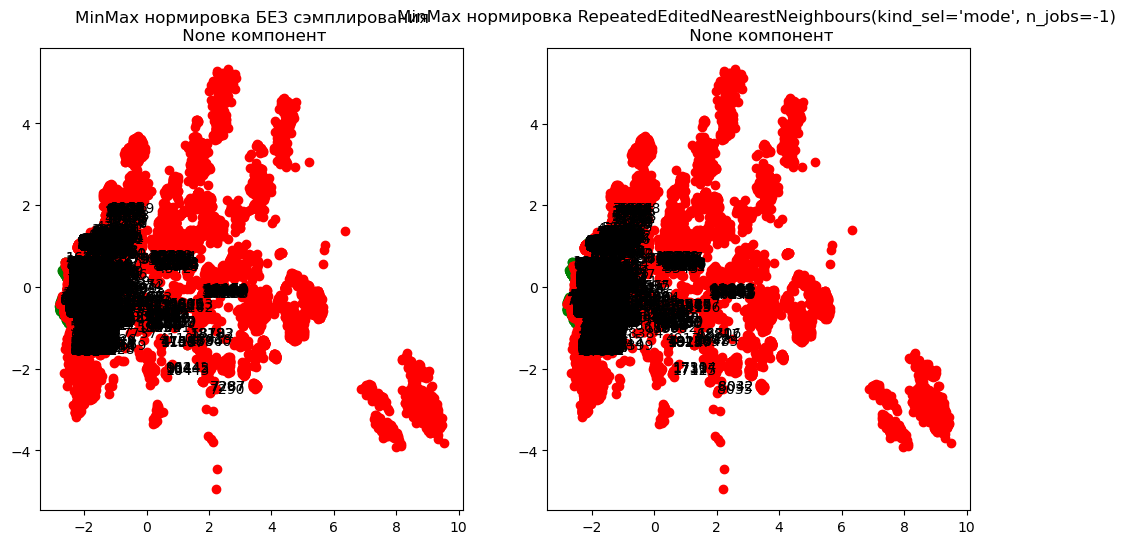

In [36]:
%%time
# n_components = 2, dimension_transformer = PCA
repeatedEditedNN_mode, repeatedEditedNN_mode_X, repeatedEditedNN_mode_y, repeatedEditedNN_mode_X_minmax, repeatedEditedNN_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=repeatedEditedNN_mode, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [37]:
repeatedEditedNN_mode_y_minmax.value_counts()

1    17213
0     1650
Name: obfuscated, dtype: int64

### AllKNN (cleaning)

#### Без аннотаций

In [39]:
allKNN_all = AllKNN(kind_sel='all')

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 8min 10s
Wall time: 2min 15s


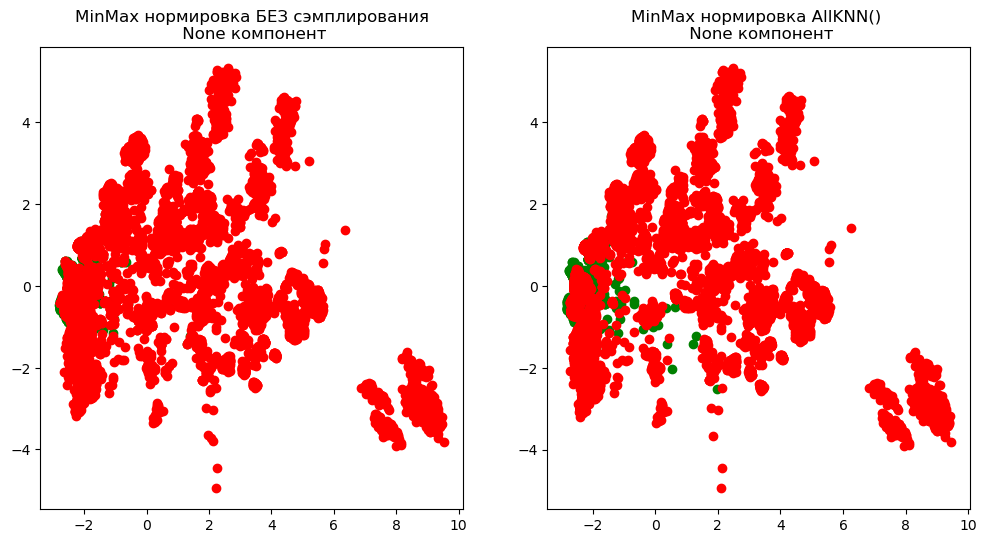

In [43]:
%%time
# n_components = 2, dimension_transformer = PCA
allKNN_all, allKNN_all_X, allKNN_all_y, allKNN_all_X_minmax, allKNN_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=allKNN_all, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1662 1663 1664 1665 1666 1667 1668 1685 1687 1688 1689 1690 1691
1692 1694 1700 1710 1712 1713 1714 1715 1716 1717 1757 1758 1759 1760 1762
1763 1764 1765 1766 1767 1768 1769 1774 1785 1788 1789 1790 1791 1792 1793
1794 1795 1815 1816 1817 1818 1819 1820 1834 1835 1838 1839 1840 1841 1842
1843 1844 1845 1860 1861 1862 1863 1864 1865 1866 1870 1880 1881 1883 1884
1885 1886 1887 1888 1892 1902 1903 1906 1907 1908 1909 1910 1911 1928 1929
1930 1931 1932 1933 1934 1935 1946 1950 1951 1952 1953 1954 1955 1956 1957
1974 1975 1976 1977 1978 1979 1980 1981 1998 2000 2001 2002 2003 2004 2005
2006 2019 2023 2024 2025 2026 2027 2042 2044 2045 2047 2048 2049 2050 2051
2052 2053 2054 2059 2060 2070 2073 2074 2075 2076 2077 2078 2079 2080 2096
2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2125 2126 2127 2128 2129
2130 2131 2144 2147 2150 2151 2152 2153 2154 2155 2156 2157 2171 2172 2173
2174 2176

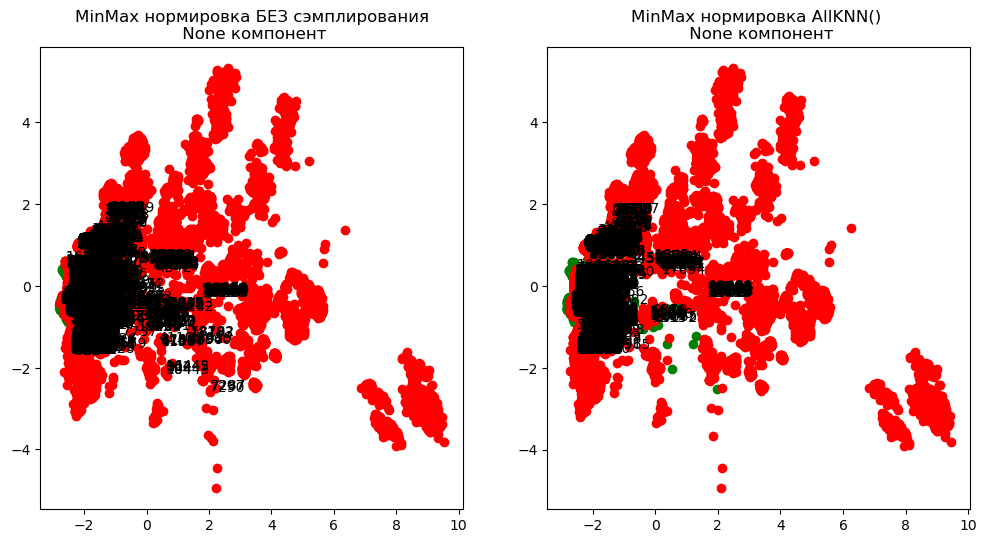

In [40]:
%%time
# n_components = 2, dimension_transformer = PCA
allKNN_all, allKNN_all_X, allKNN_all_y, allKNN_all_X_minmax, allKNN_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=allKNN_all, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [41]:
allKNN_all_y_minmax.value_counts()

1    16425
0     1650
Name: obfuscated, dtype: int64

#### Без аннотаций

In [42]:
allKNN_mode = AllKNN(kind_sel='mode')

D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is

Default data's resample was completed successfully!


D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is

MinMax scaled data's resample was completed successfully!
CPU times: total: 8min 15s
Wall time: 2min 18s


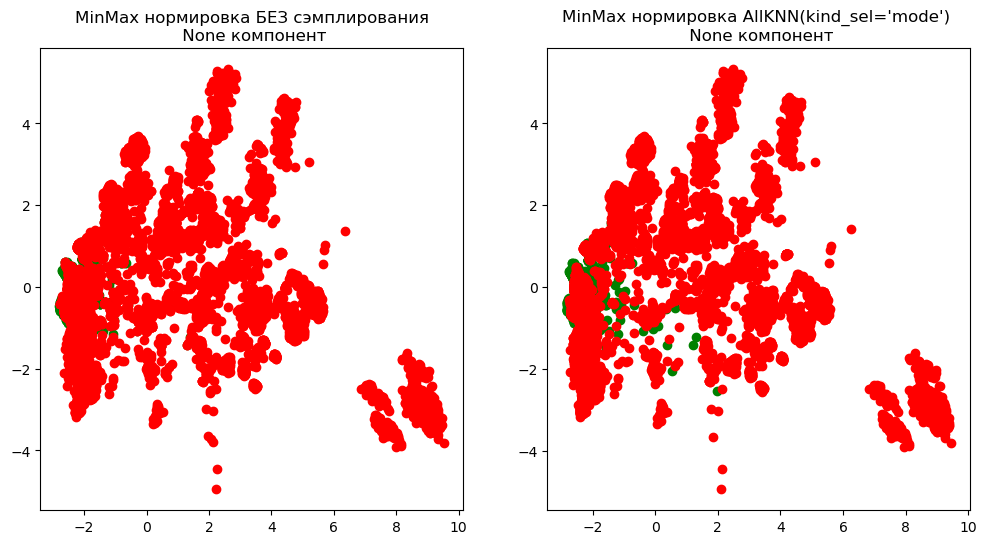

In [45]:
%%time
# n_components = 2, dimension_transformer = PCA
allKNN_mode, allKNN_mode_X, allKNN_mode_y, allKNN_mode_X_minmax, allKNN_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=allKNN_mode, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

1650 1651 1662 1663 1664 1665 1666 1667 1668 1674 1686 1688 1689 1690 1691
1692 1693 1695 1711 1713 1714 1715 1716 1717 1718 1762 1763 1764 1765 1767
1768 1769 1770 1771 1772 1773 1774 1779 1790 1793 1794 1795 1796 1797 1798
1799 1800 1820 1821 1822 1823 1824 1825 1839 1840 1843 1844 1845 1846 1847
1848 1849 1850 1865 1866 1867 1868 1869 1870 1871 1875 1885 1886 1888 1889
1890 1891 1892 1893 1897 1898 1908 1912 1913 1914 1915 1916 1917 1934 1935
1936 1937 1938 1939 1940 1941 1952 1956 1957 1958 1959 1960 1961 1962 1963
1980 1981 1982 1983 1984 1985 1986 1987 1992 1993 2005 2007 2008 2009 2010
2011 2012 2013 2026 2030 2031 2032 2033 2034 2049 2051 2052 2054 2055 2056
2057 2058 2059 2060 2061 2066 2067 2077 2080 2081 2082 2083 2084 2085 2086
2087 2103 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2132 2133 2134
2135 2136 2137 2138 2151 2154 2157 2158 2159 2160 2161 2162 2163 2164 2178
2179 2180

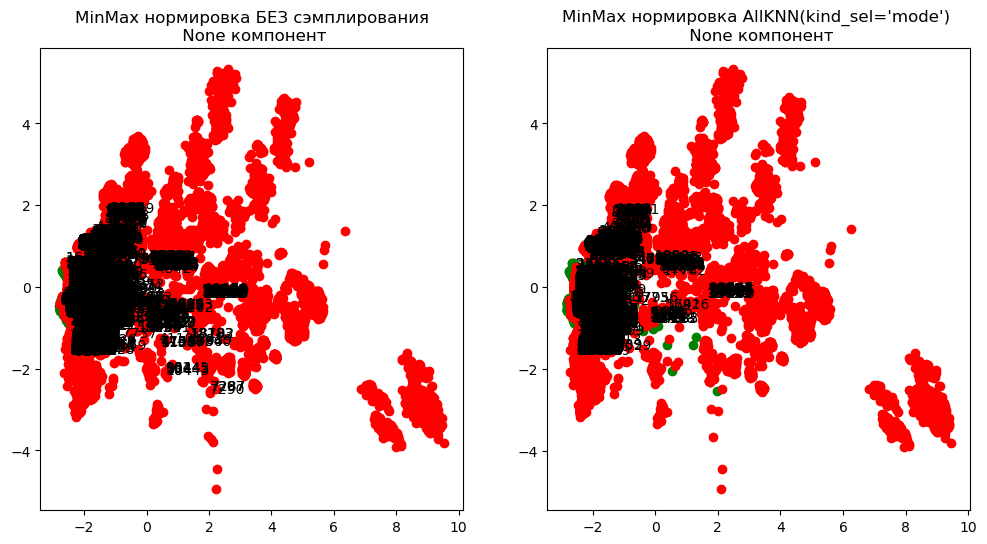

In [43]:
%%time
# n_components = 2, dimension_transformer = PCA
allKNN_mode, allKNN_mode_X, allKNN_mode_y, allKNN_mode_X_minmax, allKNN_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=allKNN_mode, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [44]:
allKNN_mode_y_minmax.value_counts()

1    16520
0     1650
Name: obfuscated, dtype: int64

### NeighbourhoodCleaningRule (cleaning)

#### Без аннотаций

In [45]:
neighbourhoodCleaningRule_all = NeighbourhoodCleaningRule(n_jobs=-1, kind_sel='all')

D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)


Default data's resample was completed successfully!


D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)


MinMax scaled data's resample was completed successfully!
CPU times: total: 3min 16s
Wall time: 59.7 s


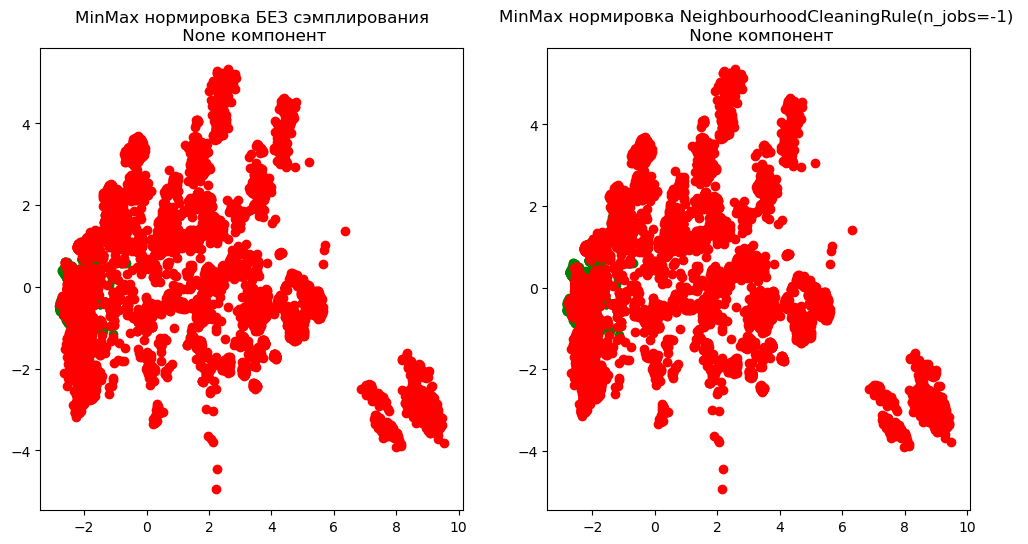

In [47]:
%%time
# n_components = 2, dimension_transformer = PCA
neighbourhoodCleaningRule_all, neighbourhoodCleaningRule_all_X, neighbourhoodCleaningRule_all_y, neighbourhoodCleaningRule_all_X_minmax, neighbourhoodCleaningRule_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=neighbourhoodCleaningRule_all, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 936 947 949 950 952 953 954 955
956 957 958 959 962 965 976 979 980 981 982 983 984 985 986
1006 1007 1008 1009 1010 1011 1025 1026 1029 1030 1031 1032 1033 1034 1035
1036 1051 1052 1053 1054 1055 1056 1057 1061 1071 1072 1074 1075 1076 1077
1078 1079 1083 1084 1094 1098 1099 1100 1101 1102 1103 1117 1120 1121 1122
1123 1124 1125 1126 1127 1138 1142 1143 1144 1145 1146 1147 1148 1149 1166
1167 1168 1169 1170 1171 1172 1173 1178 1191 1193 1194 1195 1196 1197 1198
1199 1212 1216 1217 1218 1219 1220 1221 1235 1236 1237 1238 1240 1241 1242
1243 1244 1245 1246 1247 1252 1253 1263 1266 1267 1268 1269 1270 1271 1272
1273 1289 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1303 1306 1307
1321 1322 1323 1324 1325 1326 1327 1328 1341 1344 1347 1348 1349 1350

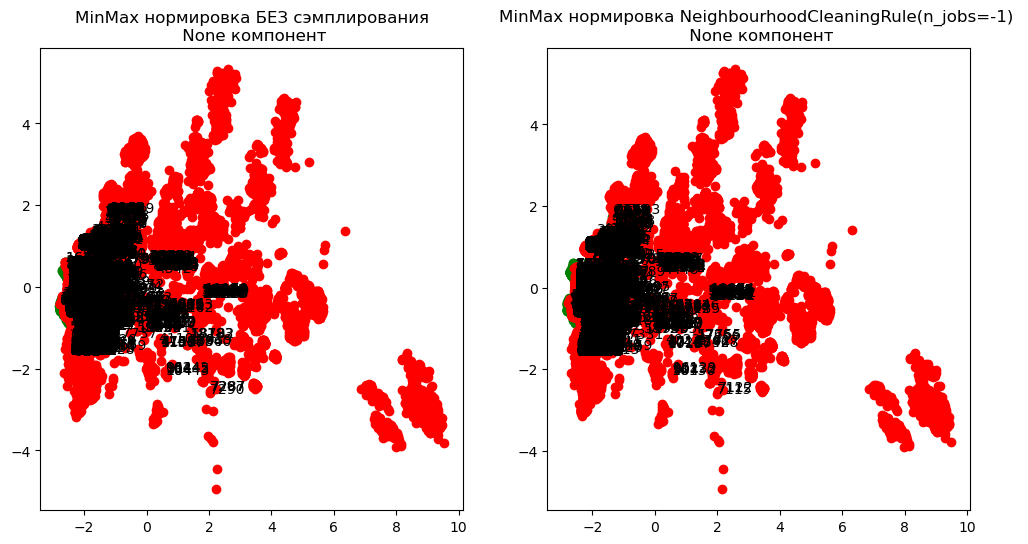

In [46]:
%%time
# n_components = 2, dimension_transformer = PCA
neighbourhoodCleaningRule_all, neighbourhoodCleaningRule_all_X, neighbourhoodCleaningRule_all_y, neighbourhoodCleaningRule_all_X_minmax, neighbourhoodCleaningRule_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=neighbourhoodCleaningRule_all, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [48]:
neighbourhoodCleaningRule_all_y_minmax.value_counts()

1    16980
0     1650
Name: obfuscated, dtype: int64

#### Без аннотаций

In [47]:
neighbourhoodCleaningRule_mode = NeighbourhoodCleaningRule(n_jobs=-1, kind_sel='mode')

D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:185: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic 

Default data's resample was completed successfully!


D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
D:\Maksim\anaconda3\envs\mlenv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:185: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic 

MinMax scaled data's resample was completed successfully!
CPU times: total: 3min 17s
Wall time: 1min 23s


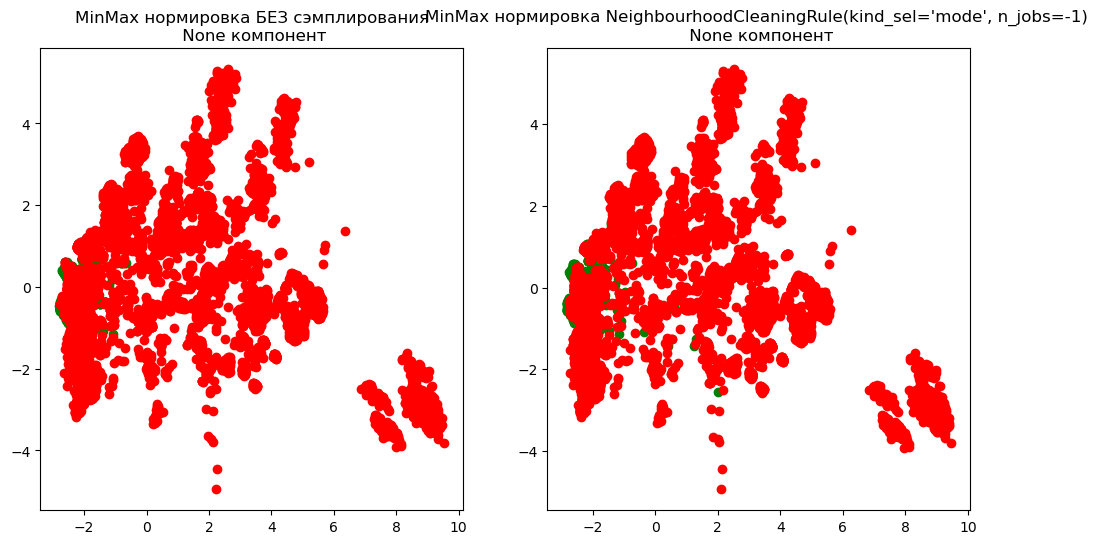

In [49]:
%%time
# n_components = 2, dimension_transformer = PCA
neighbourhoodCleaningRule_mode, neighbourhoodCleaningRule_mode_X, neighbourhoodCleaningRule_mode_y, neighbourhoodCleaningRule_mode_X_minmax, neighbourhoodCleaningRule_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=neighbourhoodCleaningRule_mode, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

822 823 834 835 836 837 838 839 840 844 847 849 850 861 863
864 865 866 867 868 870 874 877 880 881 890 892 893 894 895
896 897 902 904 911 922 929 931 934 937 948 950 951 953 954
955 956 957 958 959 960 963 966 977 980 981 982 983 984 985
986 987 1007 1008 1009 1010 1011 1012 1016 1019 1028 1029 1032 1033 1034
1035 1036 1037 1038 1039 1041 1055 1056 1057 1058 1059 1060 1061 1064 1066
1076 1077 1079 1080 1081 1082 1083 1084 1087 1089 1090 1100 1104 1105 1106
1107 1108 1109 1111 1127 1128 1129 1130 1131 1132 1133 1134 1145 1149 1150
1151 1152 1153 1154 1155 1156 1159 1174 1175 1176 1177 1178 1179 1180 1181
1184 1187 1188 1200 1202 1203 1204 1205 1206 1207 1208 1209 1211 1222 1226
1227 1228 1229 1230 1231 1234 1246 1248 1249 1251 1252 1253 1254 1255 1256
1257 1258 1261 1264 1265 1275 1278 1

Индексы обфусцированных объектов, покрывающих чистые объекты, в сбалансированной выборке.

832 833 834 835 836 837 838 844 846 857 859 860 861 862 863
864 866 872 875 884 886 887 888 889 890 891 897 938 940 941
943 944 945 946 947 948 949 950 955 966 969 970 971 972 973
974 975 976 996 997 998 999 1000 1001 1015 1016 1019 1020 1021 1022
1023 1024 1025 1026 1041 1042 1043 1044 1045 1046 1047 1051 1061 1062 1064
1065 1066 1067 1068 1069 1073 1074 1084 1088 1089 1090 1091 1092 1093 1107
1110 1111 1112 1113 1114 1115 1116 1117 1128 1132 1133 1134 1135 1136 1137
1138 1139 1153 1156 1157 1158 1159 1160 1161 1162 1163 1168 1181 1183 1184
1185 1186 1187 1188 1189 1202 1206 1207 1208 1209 1210 1211 1225 1226 1227
1228 1230 1231 1232 1233 1234 1235 1236 1237 1242 1252 1255 1256 1257 1258
1259 1260 1261 1262 1278 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289
1294 1309 1310 1311 1312 1313 1314 1315 1328 1331 1334 1335 1336 1337 1338
1339 1340 1341 1355 1356 1357 1358 1360 1361 1362 1363 1364 1

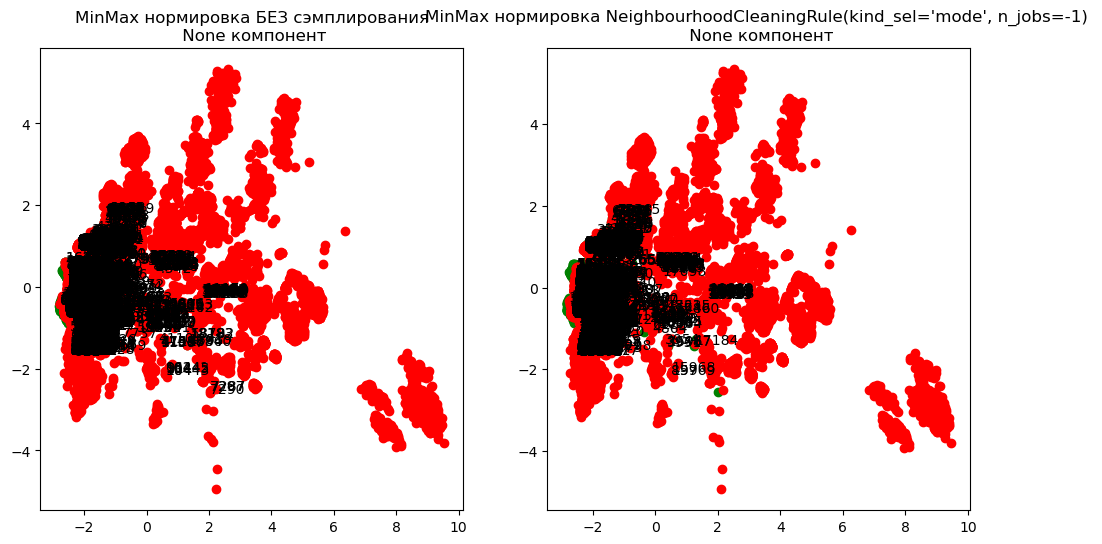

In [48]:
%%time
# n_components = 2, dimension_transformer = PCA
neighbourhoodCleaningRule_mode, neighbourhoodCleaningRule_mode_X, neighbourhoodCleaningRule_mode_y, neighbourhoodCleaningRule_mode_X_minmax, neighbourhoodCleaningRule_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=neighbourhoodCleaningRule_mode, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [50]:
neighbourhoodCleaningRule_mode_y_minmax.value_counts()

1    16696
0     1650
Name: obfuscated, dtype: int64

### InstanceHardnessThreshold (fixed - при задании размера выборки + cleaning - при задании порога уверенности)

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
iht = InstanceHardnessThreshold(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    random_state=42,
    n_jobs=-1, 
    cv=3
)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 15.3 s
Wall time: 2min 25s


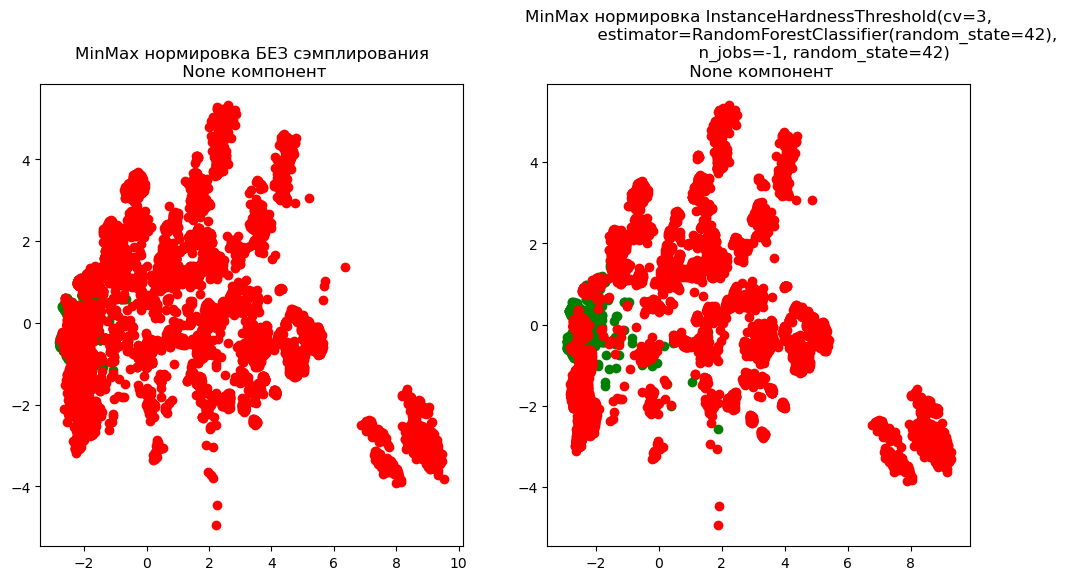

In [53]:
%%time
# n_components = 2, dimension_transformer = PCA
iht, iht_X, iht_y, iht_X_minmax, iht_y_minmax = show_imbalanced_2d_plot(imbalance_obj=iht, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

In [ ]:
%%time
# n_components = 2, dimension_transformer = PCA
iht, iht_X, iht_y, iht_X_minmax, iht_y_minmax = show_imbalanced_2d_plot(imbalance_obj=iht, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [54]:
iht_y_minmax.value_counts()

1    14109
0     1650
Name: obfuscated, dtype: int64

### NearMiss (fixed)

In [55]:
nearMiss = NearMiss(n_jobs=-1)

#### Без аннотаций

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 24.5 s
Wall time: 13.9 s


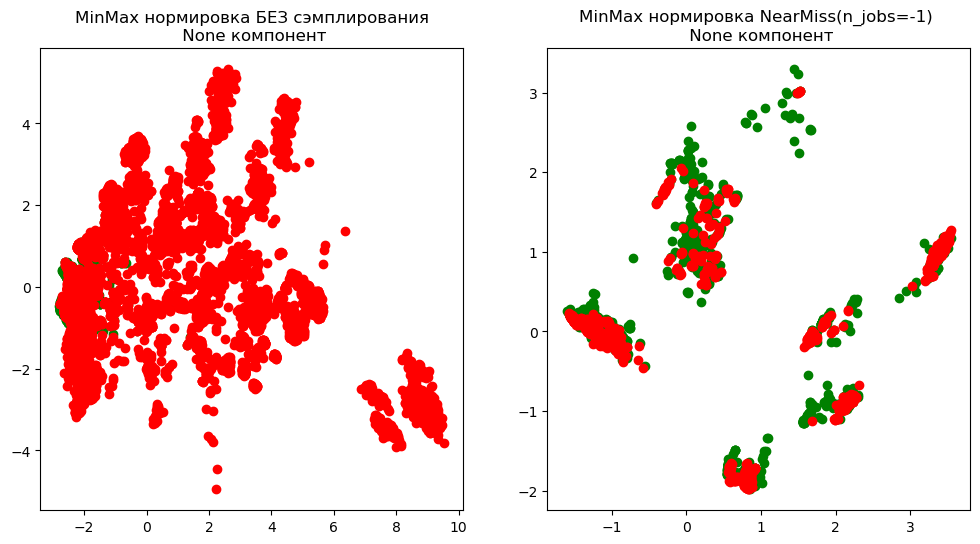

In [56]:
%%time
# n_components = 2, dimension_transformer = PCA
nearMiss, nearMiss_X, nearMiss_y, nearMiss_X_minmax, nearMiss_y_minmax = show_imbalanced_2d_plot(imbalance_obj=nearMiss, X=X, Y=y, reduction_transformer=PCA)

#### С аннотациями

In [ ]:
%%time
# n_components = 2, dimension_transformer = PCA
nearMiss, nearMiss_X, nearMiss_y, nearMiss_X_minmax, nearMiss_y_minmax = show_imbalanced_2d_plot(imbalance_obj=nearMiss, X=X, Y=y, reduction_transformer=PCA, annotate=True)

In [57]:
nearMiss_y.value_counts()

0    1650
1    1650
Name: obfuscated, dtype: int64